# <b><span style="color:#C21611;">EXTRACCIÓN DE DATOS INMOBILIARIOS EN LIMA-PERÚ</span><b>

En el contexto dinámico del mercado inmobiliario en Lima, Perú, la búsqueda de información precisa y contextualizada se ha vuelto más crucial que nunca. Este proyecto, centrado en la "Extracción de Datos Inmobiliarios en Lima-Perú", no solo se propone compilar datos esenciales sobre bienes raíces, sino que aspira a proporcionar un producto final enriquecido con información adicional. La meta es desarrollar una plataforma completa que no solo proporcione información acerca de precios y ubicaciones, sino que también incluya datos sobre el entorno circundante, tales como la cantidad de parques, supermercados, hospitales y otros elementos.

Para lograr esto tambien haremos uso de APIs, las cuales nos facilitarán la conexión y comunicación entre diferentes aplicaciones y servicios. Gracias a estas herramientas, podemos acceder fácilmente a funciones específicas sin tener que construir todo desde cero

<img src="img1.png" alt="imagen1" style="width:60%;">

### <span style="color:#1557D1;">PROPÓSITO</span><b>

Este proyecto está centrado en la recopilación, procesamiento e integración de datos relacionados con el mercado inmobiliario peruano con el fin de ofrecer una plataforma grande y detallada que sirva como una herramienta valiosa para diversos actores involucrados en el mercado.

### <span style="color:#1557D1;">OBJETIVOS</span><b>

- Desarrollar una plataforma valiosa: Con técnicas avanzadas como web scraping y preprocesamiento de datos, para presentar una visión clara y objetiva del mercado inmobiliario en Lima.

- Beneficiar a múltiples partes interesadas: El proyecto no solo tiene como objetivo informar, sino también empoderar a compradores, vendedores, agentes inmobiliarios y autoridades urbanísticas con información relevante y actualizada.

- Fomentar la transparencia y toma de decisiones informada: Al proporcionar una fuente rica de datos, el proyecto busca mejorar la transparencia del mercado inmobiliario y facilitar la toma de decisiones basadas en datos sólidos.

Utilizamos la siguiente página: https://www.laencontre.com.pe/venta/casas/lima-departamento/list. 'LaEncontré' es una página donde se realizan publicaciónes de bienes inmobiliarios en el Perú, en este caso realizamos la busqueda es en la provincia de Lima, filtrando las caracteristicas más importantes, las cuales son: precio, ubicación, área, cantidad de dormitorios y baños.

##  <span style="color:#01940E;">Web scraping para obtener las primeras 990 casas</span>

##### Obteniendo los links:

In [1]:
# Librerías
import requests
from bs4 import BeautifulSoup
import pandas as pd

base_url = "https://www.laencontre.com.pe/venta/casas/lima-departamento/list"
links = [base_url] + [f"{base_url}/p_{i}" for i in range(2, 34)]

### <span style="color:#6D12AC;">Proceso de web scraping para cada link</span>

In [2]:
df = pd.DataFrame(columns=['Precio', 'Ubicacion', 'Área (m^2)', 'Dormitorios', 'Baños','Link'])

for link in links:
    # Realizar una solicitud HTTP a la URL actual del bucle
    page = requests.get(link)

    # Verificar si la solicitud fue exitosa (código de estado 200)
    if page.status_code == 200:
        # Analizar el contenido HTML de la página usando BeautifulSoup
        soup = BeautifulSoup(page.content, 'html.parser')

        # Obtener los datos de la página actual
        precios_list = [div.text.strip() for div in soup.find_all('div', attrs={"class": "price"})]
        ubicaciones_list = [a.text.strip() if a.text.strip() else "NA" for a in soup.find_all('a', attrs={"class": "detail-redirection"})]
        areas_list = [span.text.strip() if span.text.strip() else "NA" for span in soup.find_all('span', attrs={"class": "areaBuilt"})]
        dormitorios_list = [span.text.strip() if span.text.strip() else "NA" for span in soup.find_all('span', attrs={"class": "rooms"})]
        banos_list = [span.text.strip() if span.text.strip() else "NA" for span in soup.find_all('span', attrs={"class": "bathrooms"})]
        links = soup.find_all('a', class_='detail-redirection', itemprop='url')
        urls_list = [f'https://www.laencontre.com.pe{link.get("href")}' for link in links]
        
        # Obtener la longitud máxima entre todas las listas
        max_length = max(len(precios_list), len(ubicaciones_list), len(areas_list), len(dormitorios_list), len(banos_list), len(urls_list))

        # Llenar las listas más cortas con "NA" hasta alcanzar la longitud máxima
        precios_list += ["NA"] * (max_length - len(precios_list))
        ubicaciones_list += ["NA"] * (max_length - len(ubicaciones_list))
        areas_list += ["NA"] * (max_length - len(areas_list))
        dormitorios_list += ["NA"] * (max_length - len(dormitorios_list))
        banos_list += ["NA"] * (max_length - len(banos_list))
        urls_list += ["NA"] * (max_length - len(urls_list))

        # Crear un DataFrame temporal con los datos de la página actual
        temp_df = pd.DataFrame({'Precio': precios_list,'Ubicacion': ubicaciones_list,'Área (m^2)': areas_list,
                                'Dormitorios': dormitorios_list,'Baños': banos_list, 'Link':urls_list})

        # Agregar las filas del DataFrame temporal al DataFrame principal
        df = pd.concat([df, temp_df], ignore_index=True)

    else:
        # Imprimir mensaje de error si la solicitud no fue exitosa
        print("Error al acceder a la página. Código de estado:", page.status_code)

############ MANIPULACION DE DATOS #############
        
##### Limpieza de columna 'Precio' y conversion a valores Numéricos con Tratamiento de Errores:
def limpiar_monto(precio):
    # Eliminar cualquier carácter no numérico al final del string
    cleaned_monto = ''.join(filter(str.isdigit, precio))
    return cleaned_monto
df['Precio'] = df['Precio'].apply(limpiar_monto)
# Convertir a valor numerico
df['Precio'] = pd.to_numeric(df['Precio'].replace('[\$,]', '', regex=True), errors='coerce')

##### Eliminar la subcadena "Casa en " de la columna 'Direccion'
df['Ubicacion'] = df['Ubicacion'].str.replace('Casa en ', '').str.strip()

##### Eliminar la subcadena "Casa en " de la columna 'Direccion'
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'], errors='coerce').astype('Int64')
df['Baños'] = pd.to_numeric(df['Baños'], errors='coerce').astype('Int64')

##### Conversión de la columna Área a datos de tipo númerico
# Utilizar str.extract con una expresión regular para extraer el número
df['Área (m^2)'] = df['Área (m^2)'].str.replace(',', '').str.extract('(\d+)')
# Llenar los valores NaN con 0 (o con el valor que prefieras)
df['Área (m^2)'] = df['Área (m^2)'].fillna(0).astype(float)

####### Imprimir mensaje de éxito
print("Datos guardados correctamente en el data frame")


Datos guardados correctamente en el data frame


In [3]:
df.head()

,Precio,Ubicacion,Área (m^2),Dormitorios,Baños,Link
0,850000.0,"Urb Portada De La Planicie, La Molina, Perú",618.0,7,6,https://www.laencontre.com.pe/inmueble/20d4-b9...
1,700000.0,"Naplo, Pucusana, Perú",1205.0,3,2,https://www.laencontre.com.pe/inmueble/d50e-92...
2,1250000.0,"Las Lagunas, La Molina, Perú",1054.0,5,8,https://www.laencontre.com.pe/inmueble/ab89-c0...
3,550000.0,"Cercado De Lima, Lima",400.0,5,5,https://www.laencontre.com.pe/inmueble/cd07-b6...
4,129000.0,"Jr. Mateo Avellaneda - Urb. Tungasuca, Jiron M...",120.0,4,2,https://www.laencontre.com.pe/inmueble/7d15-b8...


### <span style="color:#01940E;">API</span>

Para realizar este proyecto usamos 2 Apis de geograficos:

### <span style="color:#6D12AC;">API "HERE Geocoding API":</span>

Proporciona servicios de geocodificación, lo que significa que ofrece la capacidad de convertir direcciones o descripciones de ubicaciones en coordenadas geográficas (latitud y longitud), y viceversa. En términos más simples, permite traducir información de ubicación entre formas legibles por humanos (como direcciones) y coordenadas geográficas que las aplicaciones informáticas pueden entender.

Los posibles casos de uso para la "HERE Geocoding API" podrían incluir:

1. **Búsqueda de Ubicaciones:** Permitir a los usuarios buscar ubicaciones específicas a través de descripciones de direcciones.

2. **Visualización de Mapas:** Utilizar las coordenadas geográficas obtenidas para mostrar ubicaciones en mapas.

3. **Rastreo de Rutas:** Planificación de rutas y navegación al convertir direcciones en coordenadas utilizables para la navegación.

4. **Análisis de Datos Geográficos:** Aplicar análisis geográficos a datos basados en ubicación, como agrupación de puntos de interés.

5. **Localización en Aplicaciones:** Mejorar la precisión de la localización en aplicaciones móviles o web mediante la conversión de direcciones en coordenadas.

Para obtener detalles específicos sobre cómo utilizar la "HERE Geocoding API", se recomienda revisar la documentación oficial proporcionada por HERE: [Documentación HERE Geocoding API](https://www.here.com/docs/bundle/geocoder-api-developer-guide/page/topics/what-is.html). Esta documentación proporcionará información detallada sobre los endpoints disponibles, parámetros de solicitud y ejemplos de uso.

<b><span style="color:red;">*Nota:</span></b> Es importante tener en cuenta que la API HERE Geocoding, en su versión gratuita, presenta una limitación que restringe el número de solicitudes a 1000 por día. Esta restricción afecta la cantidad de consultas que se pueden realizar de forma gratuita en un periodo de 24 horas. Se recomienda considerar esta limitación al planificar el uso de la API y evaluar la necesidad de actualizar a una versión de pago si se requieren más solicitudes diarias.

##### Obteniendo distrito y coordenadas:

In [8]:
api_key = "obTK3-3Fvv9qKQTDeVKKaQhcPlq414d1CqBCnGuTmeA"


# Crear nuevas columnas en el DataFrame para almacenar la información extraída
df['Distrito'] = ""
df['Latitud'] = 0.0
df['Longitud'] = 0.0

# Iterar sobre las direcciones en la columna "Ubicacion"
for index, row in df.iterrows():
    direccion = row['Ubicacion']
    
    # Construir la URL con la dirección y la clave de la API
    url = f"https://geocode.search.hereapi.com/v1/geocode?q={direccion}&apiKey={api_key}"
    
    # Hacer la solicitud API
    response = requests.get(url)
    
    # Procesar la respuesta como desees
    data = response.json()
    
    # Extraer la información relevante de la respuesta
    if 'items' in data and data['items']:
        item = data['items'][0]
        city = item['address']['city']
        lat = item['position']['lat']
        lng = item['position']['lng']
        
        # Almacenar la información en el DataFrame
        df.at[index, 'Distrito'] = city
        df.at[index, 'Latitud'] = lat
        df.at[index, 'Longitud'] = lng

In [9]:
column_order = ['Precio', 'Ubicacion', 'Área (m^2)', 'Distrito','Dormitorios','Baños','Latitud','Longitud','Link']
df = df[column_order]
df_c = df
df.head()

,Precio,Ubicacion,Área (m^2),Distrito,Dormitorios,Baños,Latitud,Longitud,Link
0,850000.0,"Urb Portada De La Planicie, La Molina, Perú",618.0,La Molina,7,6,-12.07833,-76.92146,https://www.laencontre.com.pe/inmueble/20d4-b9...
1,700000.0,"Naplo, Pucusana, Perú",1205.0,Pucusana,3,2,-12.47902,-76.79266,https://www.laencontre.com.pe/inmueble/d50e-92...
2,1250000.0,"Las Lagunas, La Molina, Perú",1054.0,La Molina,5,8,-12.08122,-76.92057,https://www.laencontre.com.pe/inmueble/ab89-c0...
3,550000.0,"Cercado De Lima, Lima",400.0,Lima,5,5,-12.05030,-77.03662,https://www.laencontre.com.pe/inmueble/cd07-b6...
4,129000.0,"Jr. Mateo Avellaneda - Urb. Tungasuca, Jiron M...",120.0,Carabayllo,4,2,-11.89364,-77.04273,https://www.laencontre.com.pe/inmueble/7d15-b8...


### <span style="color:#6D12AC;">API “Overpass API”:</span>

Es una herramienta que proporciona acceso a datos geoespaciales almacenados en OpenStreetMap (OSM). OpenStreetMap es un proyecto colaborativo de mapeo en línea que recopila información geográfica de todo el mundo y la pone a disposición de manera gratuita. La "Overpass API" permite a los desarrolladores y usuarios realizar consultas específicas para extraer datos detallados de OSM.

Algunos de los posibles casos de uso y aplicaciones de la "Overpass API" incluyen:

1. **Recopilación de Datos Geoespaciales:** Permite a los usuarios extraer información detallada sobre objetos geográficos, como carreteras, edificios, parques, etc., desde la base de datos de OpenStreetMap.

2. **Análisis de Datos:** Facilita la obtención de datos específicos para realizar análisis geoespaciales y generar estadísticas sobre características específicas del terreno.

3. **Desarrollo de Mapas Personalizados:** Los desarrolladores pueden utilizar la "Overpass API" para obtener datos específicos y personalizar mapas según sus necesidades.

4. **Planificación de Rutas:** Permite a las aplicaciones de navegación obtener información detallada sobre carreteras, calles y otros elementos geográficos para la planificación de rutas.

5. **Visualización de Datos:** Ayuda en la visualización de datos geográficos específicos en aplicaciones y servicios web.

Para utilizar la "Overpass API", los usuarios envían consultas específicas mediante un lenguaje de consulta llamado Overpass Query Language (Overpass QL). Estas consultas permiten filtrar y seleccionar datos específicos de la base de datos de OpenStreetMap.

Es importante tener en cuenta que la "Overpass API" está diseñada principalmente para usuarios técnicos y desarrolladores familiarizados con la manipulación de datos geoespaciales y consultas API. Si estás interesado en utilizarla, te recomendaría revisar la documentación oficial de Overpass API para obtener detalles específicos y ejemplos de cómo realizar consultas: [Documentación Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API).

In [10]:
# Crear nuevas columnas en el DataFrame para almacenar la información extraída
df['n° colegios (radio 1500m)'] = 0
df['n° parques/areas verdes (radio 800m)'] = 0
df['n° hospitales (radio 2000m)'] = 0
df['n° restaurantes (radio 800m)'] = 0
df['n° supermercados (radio 1000m)'] = 0
df['n° gasolineras (radio 1000m)'] = 0

for index, row in df.iterrows():
    lat = row['Latitud']
    long = row['Longitud']
    
    url_1 = f"https://overpass-api.de/api/interpreter?data=[out:json];nwr(around:1500,{lat},{long})['amenity'='school'];out count;"   
    # Hacer la solicitud API
    response_1 = requests.get(url_1)
    data_1 = response_1.json()
    nodes_col = int(data_1['elements'][0]['tags']['nodes'])
    df.at[index,'n° colegios (radio 1500m)'] = nodes_col
    
    url_2 = f"https://overpass-api.de/api/interpreter?data=[out:json];nwr(around:800,{lat},{long})['leisure'='park'];(._;>;);out count;"   
    # Hacer la solicitud API
    response_2 = requests.get(url_2)
    data_2 = response_2.json()
    ways_par = int(data_2['elements'][0]['tags']['ways'])
    df.at[index,'n° parques/areas verdes (radio 800m)'] = ways_par
    
    url_3 = f"https://overpass-api.de/api/interpreter?data=[out:json];nwr(around:2000,{lat},{long})['amenity'='hospital'];(._;>;);out count;"   
    # Hacer la solicitud API
    response_3 = requests.get(url_3)
    data_3 = response_3.json()
    ways_h = int(data_3['elements'][0]['tags']['ways'])
    df.at[index,'n° hospitales (radio 2000m)'] = ways_h
    
    url_4 = f" https://overpass-api.de/api/interpreter?data=[out:json];nwr(around:800,{lat},{long})['amenity'='restaurant'];(._;>;);out count;"   
    # Hacer la solicitud API
    response_4 = requests.get(url_4)
    data_4 = response_4.json()
    nodes_r = int(data_4['elements'][0]['tags']['nodes'])
    df.at[index,'n° restaurantes (radio 800m)'] = nodes_r

    url_5 = f"https://overpass-api.de/api/interpreter?data=[out:json];nwr(around:1000,{lat},{long})['shop'='supermarket'];out count;"   
    # Hacer la solicitud API
    response_5 = requests.get(url_5)
    data_5 = response_5.json()
    total_s = int(data_5['elements'][0]['tags']['total'])
    df.at[index,'n° supermercados (radio 1000m)'] = total_s

    url_6 = f"https://overpass-api.de/api/interpreter?data=[out:json];nwr(around:1000,{lat},{long})['amenity'='fuel'];(._;>;);out count;"   
    # Hacer la solicitud API
    response_6 = requests.get(url_6)
    data_6 = response_6.json()
    ways_g = int(data_6['elements'][0]['tags']['total'])
    df.at[index,'n° gasolineras (radio 1000m)'] = ways_g
    

In [11]:
df.head()

,Precio,Ubicacion,Área (m^2),Distrito,Dormitorios,Baños,Latitud,Longitud,Link,n° colegios (radio 1500m),n° parques/areas verdes (radio 800m),n° hospitales (radio 2000m),n° restaurantes (radio 800m),n° supermercados (radio 1000m),n° gasolineras (radio 1000m)
0,850000.0,"Urb Portada De La Planicie, La Molina, Perú",618.0,La Molina,7,6,-12.07833,-76.92146,https://www.laencontre.com.pe/inmueble/20d4-b9...,6,6,0,2,3,1
1,700000.0,"Naplo, Pucusana, Perú",1205.0,Pucusana,3,2,-12.47902,-76.79266,https://www.laencontre.com.pe/inmueble/d50e-92...,14,3,0,0,0,1
2,1250000.0,"Las Lagunas, La Molina, Perú",1054.0,La Molina,5,8,-12.08122,-76.92057,https://www.laencontre.com.pe/inmueble/ab89-c0...,8,7,0,2,4,1
3,550000.0,"Cercado De Lima, Lima",400.0,Lima,5,5,-12.05030,-77.03662,https://www.laencontre.com.pe/inmueble/cd07-b6...,75,9,20,107,7,16
4,129000.0,"Jr. Mateo Avellaneda - Urb. Tungasuca, Jiron M...",120.0,Carabayllo,4,2,-11.89364,-77.04273,https://www.laencontre.com.pe/inmueble/7d15-b8...,65,37,3,22,1,24


### <span style="color:#01940E;"> Guardar el DataFrame en un archivo Excel y CSV

In [12]:
df.to_excel('datos_inmobiliarios.xlsx', index=False)
df.to_csv("datos_inmobiliarios.csv", index=False, encoding='utf-8')

### <span style="color:#01940E;">Visualizacion de la distribución Geográfica de las Propiedades en Venta

In [13]:
df_csv = pd.read_csv('datos_inmobiliarios.csv')

In [14]:
import folium

# Crear un mapa centrado en la ubicación promedio
mapa = folium.Map(location=[df_csv['Latitud'].mean(), df_csv['Longitud'].mean()], zoom_start=10)

# Añadir marcadores al mapa
for index, row in df_csv.iterrows():
    folium.Marker([row['Latitud'], row['Longitud']], popup=row['Ubicacion']).add_to(mapa)

# Mostrar el mapa
mapa.save("mapa.html")

### <span style="color:#01940E;">Creación de una tabla dinámica (Librerias Pandas y PivotTableJS)

In [15]:
# Librería
import pandas as pd

In [21]:
pip install pivottablejs

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Libreria
from pivottablejs import pivot_ui

In [17]:
# Leer el archivo Excel
df_1= pd.read_excel('datos_inmobiliarios.xlsx', sheet_name ='Sheet1')
#eliminar filas con valores nulos
df_1_clean = df_1.dropna()

In [18]:
# Crear la tabla dinámica
pivot_ui(df_1_clean)

### <span style="color:#01940E;">Visualización de Datos

A continuación, se presentan algunos gráficos que proporcionan una representación visual de la información contenida en nuestros datos.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

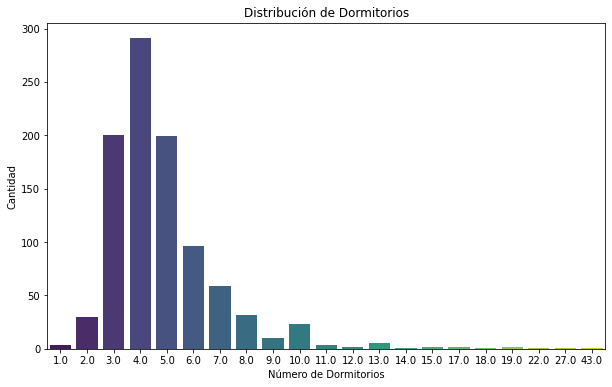

In [20]:
# Gráfico de barras o circular: Distribución de dormitorios o baños
plt.figure(figsize=(10, 6))
sns.countplot(x='Dormitorios', data=df_csv, palette='viridis')
plt.title('Distribución de Dormitorios')
plt.xlabel('Número de Dormitorios')
plt.ylabel('Cantidad')
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


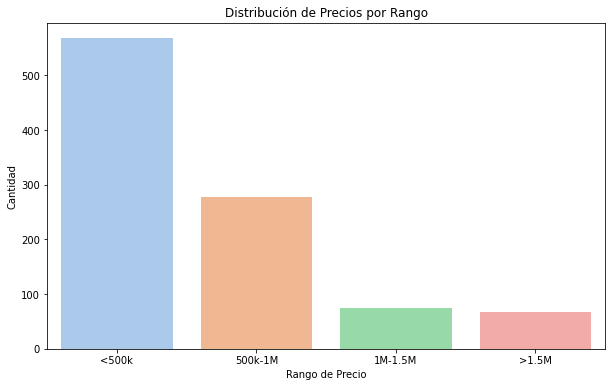

In [21]:
# Crear un rango de precios
price_ranges = pd.cut(df_csv['Precio'], bins=[0, 500000, 1000000, 1500000, float('inf')], labels=['<500k', '500k-1M', '1M-1.5M', '>1.5M'])

# Calcular frecuencias
price_ranges_counts = price_ranges.value_counts()

# Grafico de barras para la distribución de precios por rango
plt.figure(figsize=(10, 6))
sns.barplot(x=price_ranges_counts.index, y=price_ranges_counts, palette='pastel')
plt.title('Distribución de Precios por Rango')
plt.xlabel('Rango de Precio')
plt.ylabel('Cantidad')
plt.show()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

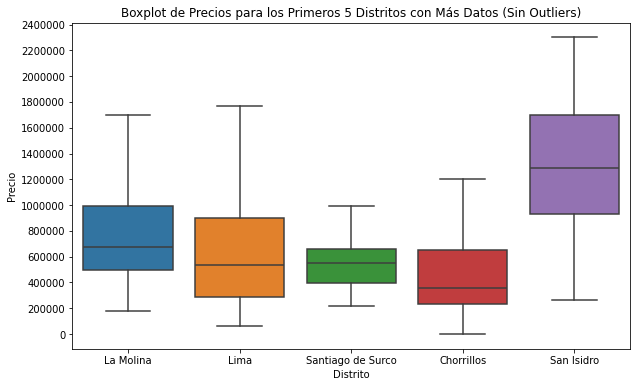

In [22]:
plt.figure(figsize=(10, 6))

# Obtener los primeros 5 distritos con más datos
distritos_top5_mas_datos = df_csv['Distrito'].value_counts().head(5).index

# Filtrar el DataFrame para incluir solo los primeros 5 distritos con más datos
df_top5_mas_datos = df_csv[df_csv['Distrito'].isin(distritos_top5_mas_datos)]

# Crear el boxplot sin outliers
sns.boxplot(x='Distrito', y='Precio', data=df_top5_mas_datos, showfliers=False)
plt.title('Boxplot de Precios para los Primeros 5 Distritos con Más Datos (Sin Outliers)')

# Desactivar la notación científica en el eje y
plt.ticklabel_format(style='plain', axis='y')
plt.locator_params(axis='y', nbins=20)

plt.show()

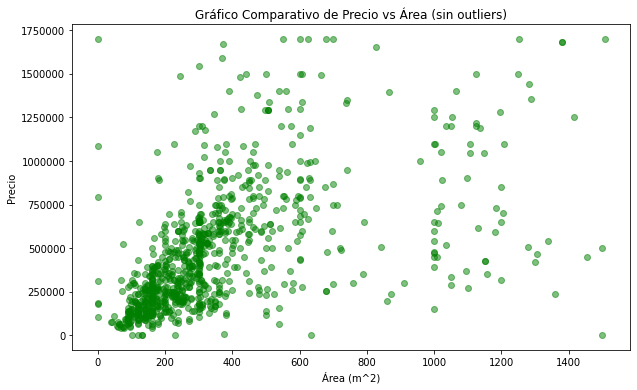

In [23]:
plt.figure(figsize=(10, 6))

# Definir umbral como percentil 95 para 'Precio' y 'Área (m^2)'
threshold_precio = np.percentile(df_csv['Precio'].dropna(), 95)
threshold_area = np.percentile(df_csv['Área (m^2)'].dropna(), 95)

# Filtrar datos eliminando outliers en 'Precio' y 'Área (m^2)'
df_filtered = df_csv[(df_csv['Precio'] < threshold_precio) & (df_csv['Área (m^2)'] < threshold_area)]

# Crear el gráfico con los datos filtrados
plt.scatter(df_filtered['Área (m^2)'], df_filtered['Precio'], color='green', alpha=0.5)
plt.title('Gráfico Comparativo de Precio vs Área (sin outliers)')
plt.xlabel('Área (m^2)')
plt.ylabel('Precio')

# Desactivar la notación científica en el eje y
plt.ticklabel_format(style='plain', axis='y')

plt.show()